In [1]:
from utils.create_embedding_feautres import create_embedding_features
from utils.dvrl_utils import calc_qwk, get_dev_sample, fit_func, pred_func, remove_top_p_sample
from utils.general_utils import get_overall_score_range
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix
import polars as pl

/Users/takumishibata/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## memo

-p1 80%
-p2 60%
-p3 70%
-p4 50%
-p5 60%
-p6 10%
-p7 30%
-p8 30%

# 分析用データフレームの作成

## BERTの場合

In [52]:
test_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]
top_p_list = [0.8, 0.6, 0.7, 0.5, 0.6, 0.1, 0.3, 0.3]

prompt_arr = []
df_list = []
for test_prompt_id, top_p in zip(test_prompt_ids, top_p_list):
    
    train_data, valid_data, test_data = create_embedding_features(f'data/cross_prompt_attributes/{test_prompt_id}/', 'score', 'microsoft/deberta-v3-large', 'cpu')
    # split test data into dev and test
    x_dev, x_test, y_dev, y_test, dev_idx, test_idx = get_dev_sample(test_data['essay'], test_data['normalized_label'], dev_size=30)

    weights = remove_top_p_sample(np.load('outputs/Estimated_Data_Values/DVRL-word/' + f'estimated_data_value{test_prompt_id}.npy'), top_p=top_p, ascending=False)
    source_data_ids = np.concatenate([train_data['essay_id'], valid_data['essay_id']], axis=0)

    df = pl.DataFrame({'item_id': source_data_ids,
                       f'weights_for_prompt{test_prompt_id}': np.array([bool(w) for w in weights])
                       }).sort('item_id')
    df_list.append(df)

load data from data/cross_prompt_attributes/1/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1184, 653, 878, 446, 282, 1548, 1244, 452, 1447, 916, 945, 871, 689, 1368, 476, 746, 1570, 1645, 1509, 1299, 151, 1549, 622, 1347, 915, 908, 690, 1577, 305, 1359]
load data from data/cross_prompt_attributes/2/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [428, 1298, 765, 955, 244, 995, 988, 1215, 1398, 573, 1140, 182, 310, 1195, 900, 519, 1710, 1515, 1622, 1632, 1000, 1055, 502, 1276, 1006, 1333, 1198, 725, 366, 1629]
load data from data/cross_prompt_attributes/3/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [655, 1005, 785, 396, 28, 960, 1302, 1434, 1387, 941, 1576, 1327, 914, 1620, 1673, 1422, 1529, 485, 530, 1278, 1573, 1035, 942, 101, 173, 592, 1571, 1227, 409, 1316]
load data from data/cross_prompt_attributes/4/...
Loading embedding from cache...
Selected 30 samples.
Selected sample 

In [53]:
df_for_analysis = pl.read_csv("data/hand_crafted_v3.csv")
for i in range(len(df_list)):
    df_for_analysis = df_for_analysis.join(df_list[i], on='item_id', how='left')

In [68]:
f_col = {
    'word_count': '単語数',
    # 'mean_word': '平均単語数',
    # 'word_var': '単語長の分散',
    'mean_sent': '平均文数',
    # 'sent_var': '文数の分散',
    # 'ess_char_len': '文字数',
    # 'prep_comma': 'コンマと前置詞の数',
    # 'unique_word': 'ユニーク単語数',
    # 'clause_per_s': '文あたりの節の数',
    # 'mean_clause_l': '平均節の長さ',
    # 'max_clause_in_s': '文あたりの最大節の長さ',
    'spelling_err': 'スペルミスの数',
    # 'sent_ave_depth': '文の平均深さ',
    # 'ave_leaf_depth': '葉の平均深さ',
    'automated_readability': '可読性',
    # 'linsear_write': '可読性2',
    # 'stop_prop': 'ストップワードの割合',
    # 'positive_sentence_prop': 'ポジティブな文の割合',
    # 'negative_sentence_prop': 'ネガティブな文の割合',
    # 'neutral_sentence_prop': 'ニュートラルな文の割合',
    # 'overall_positivity_score': '全体のポジティブ度',
    # 'overall_negativity_score': '全体のネガティブ度',
    #  ',',
    #  '.',
    #  'VB',
    #  'JJR',
    #  'WP',
    #  'PRP$',
    #  'VBN',
    #  'VBG',
    #  'IN',
    #  'CC',
    #  'JJS',
    #  'PRP',
    #  'MD',
    #  'WRB',
    #  'RB',
    #  'VBD',
    #  'RBR',
    #  'VBZ',
    #  'NNP',
    #  'POS',
    #  'WDT',
    #  'DT',
    #  'CD',
    #  'NN',
    #  'TO',
    #  'JJ',
    #  'VBP',
    #  'RP',
    #  'NNS',
}

In [69]:
# Normalize the weights columns to [0, 1] range
weight_columns = [col for col in df_for_analysis.columns if col in f_col]
for col in weight_columns:
    min_val = df_for_analysis[col].min()
    max_val = df_for_analysis[col].max()
    df_for_analysis = df_for_analysis.with_columns(
        ((pl.col(col) - min_val) / (max_val - min_val)).alias(col)
    )

# Get the score ranges for each prompt
score_ranges = get_overall_score_range()

# Normalize the score column based on prompt-specific min and max values
df_for_analysis = df_for_analysis.with_columns(
    pl.struct(['prompt_id', 'score']).map_elements(
        lambda x: (x['score'] - score_ranges[x['prompt_id']][0]) / (score_ranges[x['prompt_id']][1] - score_ranges[x['prompt_id']][0]),
        return_dtype=pl.Float64
    ).alias('normalized_score')
)

In [70]:
df_for_analysis.filter(pl.col('prompt_id') == 1).group_by('score').mean().sort('score')

score,item_id,prompt_id,mean_word,word_var,mean_sent,sent_var,ess_char_len,word_count,prep_comma,unique_word,clause_per_s,mean_clause_l,max_clause_in_s,spelling_err,sent_ave_depth,ave_leaf_depth,automated_readability,linsear_write,stop_prop,positive_sentence_prop,negative_sentence_prop,neutral_sentence_prop,overall_positivity_score,overall_negativity_score,",",.,VB,JJR,WP,PRP$,VBN,VBG,IN,CC,JJS,PRP,MD,WRB,RB,VBD,RBR,VBZ,NNP,POS,WDT,DT,CD,NN,TO,JJ,VBP,RP,NNS,weights_for_prompt1,weights_for_prompt2,weights_for_prompt3,weights_for_prompt4,weights_for_prompt5,weights_for_prompt6,weights_for_prompt7,weights_for_prompt8,normalized_score
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.0,925.4,1.0,4.313338,4.524874,0.042766,6.635111,122.2,0.024906,3.6,19.2,0.083333,1.2,0.2,0.013527,4.05,2.030839,0.036654,8.82,0.498785,0.723333,0.15,0.126667,0.471628,0.02984,0.019643,0.065702,0.044817,0.0,0.007341,0.019983,0.00351,0.005098,0.088176,0.036018,0.0,0.068227,0.015099,0.001587,0.024348,0.0,0.0,0.033658,0.024364,0.0,0.0,0.060562,0.0,0.1142,0.033084,0.096731,0.097981,0.00351,0.095152,NaN,1.0,0.0,0.7,1.0,0.8,1.0,0.0,0.0
3.0,22.0,1.0,4.625,3.305804,0.088435,4.0,259.0,0.050752,8.0,28.0,0.5,5.0,1.0,0.014493,7.5,3.068966,0.068061,17.25,0.558271,1.0,0.0,0.0,0.32,0.0,0.0,0.033898,0.050847,0.0,0.0,0.067797,0.016949,0.016949,0.135593,0.050847,0.0,0.0,0.016949,0.0,0.0,0.0,0.0,0.0,0.067797,0.0,0.0,0.118644,0.0,0.186441,0.033898,0.033898,0.050847,0.016949,0.101695,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.1
4.0,809.764706,1.0,4.326588,4.733132,0.073324,95.978523,413.823529,0.089617,12.941176,39.176471,0.361625,5.156863,1.058824,0.046888,5.160084,2.752832,0.061597,16.10042,0.466769,0.540616,0.193277,0.266106,0.583228,0.046099,0.019564,0.051078,0.057893,0.004836,0.001622,0.012523,0.007717,0.023538,0.102046,0.042284,0.000958,0.071427,0.030292,0.008548,0.038159,0.00633,0.001898,0.025266,0.021394,0.001425,0.002029,0.065848,0.001884,0.124751,0.023284,0.067503,0.062156,0.005861,0.091838,NaN,0.823529,0.0,0.352941,0.588235,0.647059,1.0,0.882353,0.2
5.0,950.529412,1.0,4.295026,4.50122,0.09981,162.736569,582.941176,0.126327,18.352941,50.411765,0.510565,6.767647,1.235294,0.055129,5.562129,2.807003,0.075272,17.230462,0.486284,0.56741,0.116947,0.315643,0.649584,0.001574,0.0142,0.043088,0.075887,0.006389,0.003364,0.010263,0.005603,0.018922,0.109004,0.046698,0.002597,0.065645,0.033323,0.005752,0.047582,0.004608,0.000835,0.019595,0.024469,0.003301,0.002619,0.062532,0.003572,0.124345,0.029896,0.062603,0.059755,0.005875,0.087325,NaN,1.0,0.0,0.294118,0.411765,0.764706,1.0,0.941176,0.3
6.0,852.672727,1.0,4.280903,4.524767,0.064932,132.349335,825.418182,0.180357,27.754545,67.827273,0.351176,7.383019,1.4,0.074616,5.233547,2.663744,0.055526,13.395581,0.471108,0.572637,0.132376,0.294987,0.699573,0.005635,0.022731,0.051145,0.066967,0.004117,0.004189,0.016,0.006746,0.018874,0.104311,0.040872,0.0017,0.073271,0.027623,0.008167,0.048092,0.005587,0.001394,0.022713,0.033937,0.002932,0.002592,0.068567,0.002616,0.122013,0.02867,0.057029,0.057184,0.00664,0.076504,NaN,1.0,0.0,0.045455,0.0,0.7,1.0,1.0,0.4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
8.0,904.05968,1.0,4.343751,4.802274,0.052382,98.430848,1443.234352,0.311046,48.331878,101.135371,0.312945,6.88233,1.557496,0.116666,4.800991,2.523453,0.04565,10.87152,0.474044,0.504742,0.166066,0.329192,0.662864,0.013712,0.027621,0.05469,0.062413,0.005195,0.003958,0.01889,0.008695,0.020957,0.099818,0.036429,0.001761,0.071408,0.024889,0.008269,0.052294,0.008437,0.001843,0.023477,0.032277,0.001073,0.003336,0.070599,0.003072,0.125716,0.029692,0.055551,0.056328,0.005563,0.070997,NaN,0.727802,0.001456,0.193595,0.0,1.0,0.167394,1.0,0.6
9.0,942.326347,1.0,4.41831,5.058657,0.05079

/var/folders/7j/d1bzg7hs3931c2d8kcrbhcl80000gn/T/ipykernel_48560/2861310784.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels([col for col in f_col.values()] + ['得点'], rotation=45, fontsize=16)
/var/folders/7j/d1bzg7hs3931c2d8kcrbhcl80000gn/T/ipykernel_48560/2861310784.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels([col for col in f_col.values()] + ['得点'], rotation=45, fontsize=16)
/var/folders/7j/d1bzg7hs3931c2d8kcrbhcl80000gn/T/ipykernel_48560/2861310784.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels([col for col in f_col.values()] + ['得点'], rotation=45, fontsize=16)
/var/folders/7j/d1bzg7hs3931c2d8kcrbhcl80000gn/T/ipykernel_48560/28

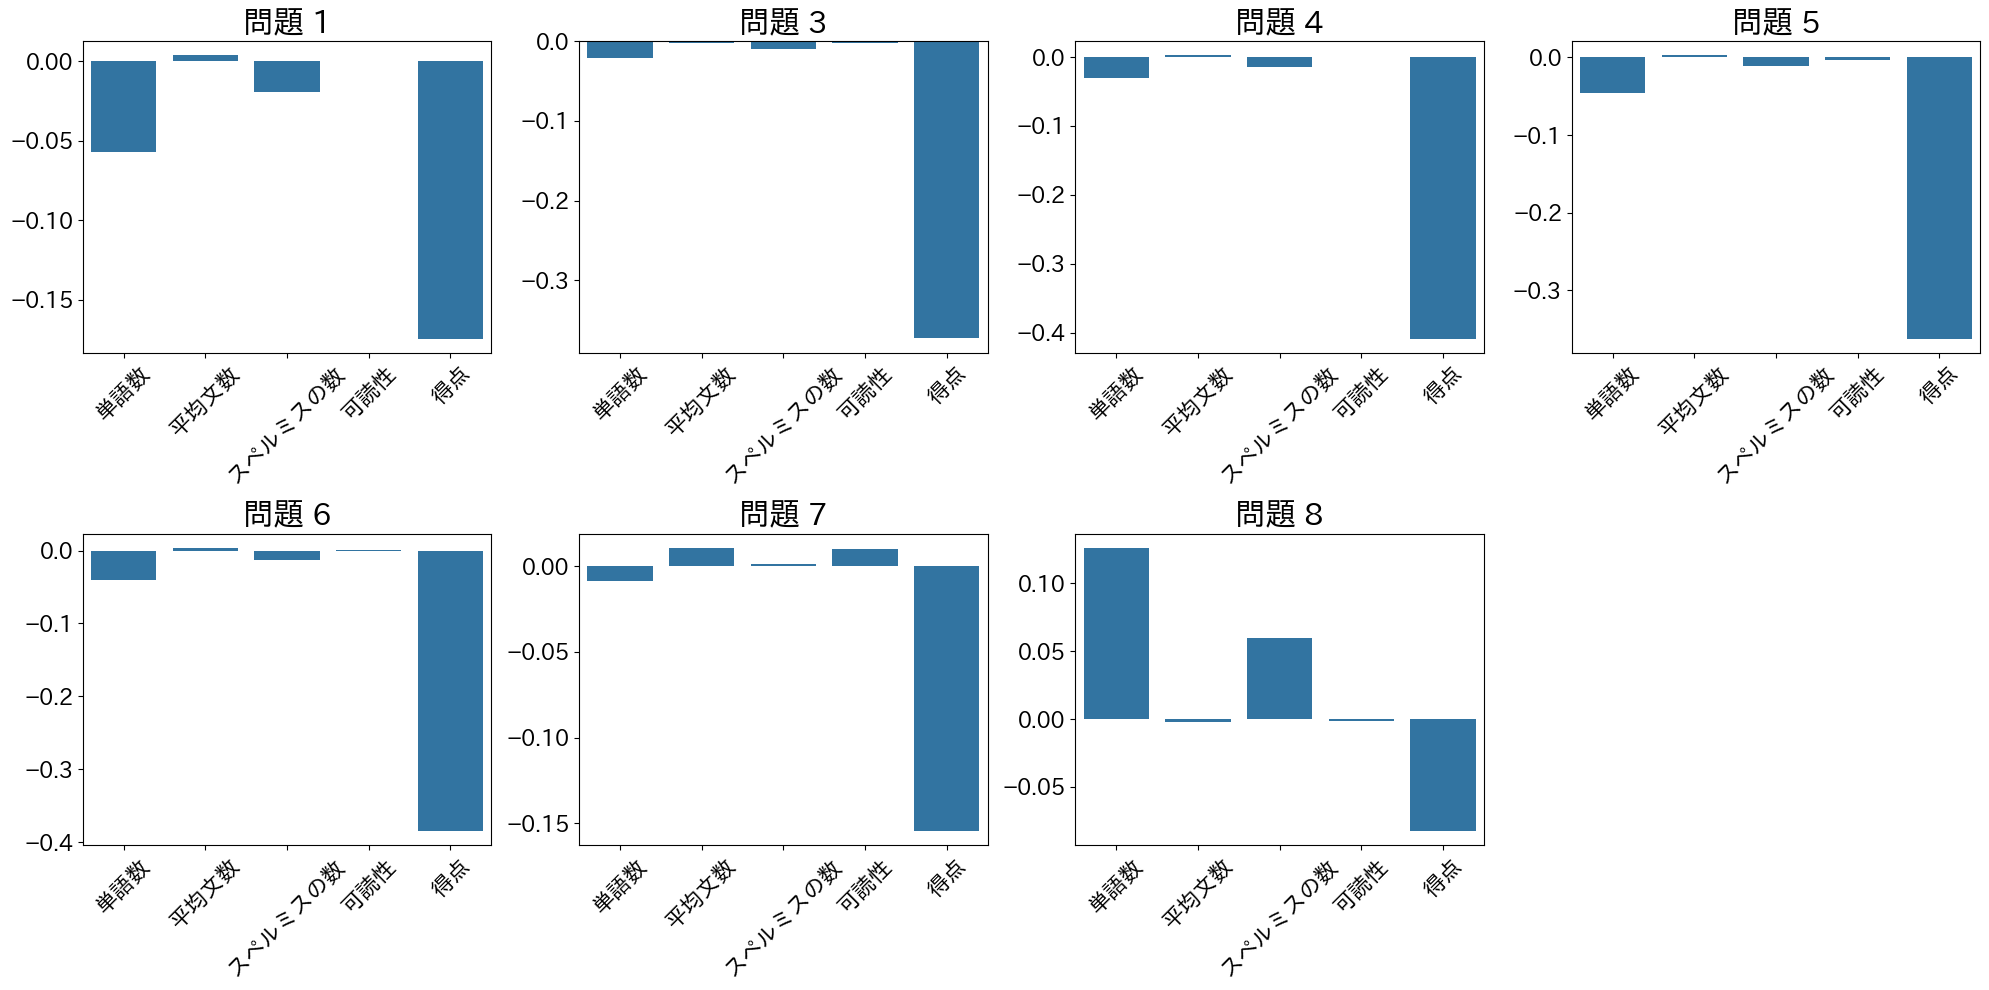

In [71]:
# Loop through prompt_ids 1-8, skipping prompt2
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
# fig.suptitle('採択された小論文データとそうでない小論文データにおける各種特徴量の平均値の差', fontsize=20)

plot_index = 0
for prompt_id in range(1, 9):
    if prompt_id == 2:
        continue
    
    # Calculate means for True and False groups in weights_for_prompt2
    means = df_for_analysis.filter(
        pl.col('prompt_id') == prompt_id
    ).group_by(
        f'weights_for_prompt2'
    ).agg([pl.col(col).mean() for col in f_col.keys()]+[pl.col('normalized_score').mean()]
    ).sort(f'weights_for_prompt2', descending=True)

    # Calculate the difference between True and False groups
    diff = means.filter(pl.col(f'weights_for_prompt2') == True).select(pl.all().exclude(f'weights_for_prompt2')) - \
           means.filter(pl.col(f'weights_for_prompt2') == False).select(pl.all().exclude(f'weights_for_prompt2'))

    # Melt the difference DataFrame for easier plotting
    diff_melted = diff.melt(variable_name='feature', value_name='difference')

    # Create a bar plot to visualize the differences
    row = plot_index // 4
    col = plot_index % 4
    sns.barplot(data=diff_melted.to_pandas(), x='feature', y='difference', ax=axs[row, col])
    axs[row, col].set_xticklabels([col for col in f_col.values()] + ['得点'], rotation=45, fontsize=16)
    axs[row, col].set_title(f'問題 {prompt_id}', fontsize=22)
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel('')
    
    # Set y-axis tick size
    axs[row, col].tick_params(axis='y', labelsize=16)
    
    # Adjust y-axis limits to be consistent across all subplots
    # axs[row, col].set_ylim(-0.2, 0.2)
    
    plot_index += 1

# Remove the unused subplot
fig.delaxes(axs[1, 3])

plt.tight_layout()
plt.savefig('outputs/figures/feature_difference.png')

In [9]:
df_for_analysis.filter(pl.col('weights_for_prompt3') == True).describe()

statistic,item_id,prompt_id,mean_word,word_var,mean_sent,sent_var,ess_char_len,word_count,prep_comma,unique_word,clause_per_s,mean_clause_l,max_clause_in_s,spelling_err,sent_ave_depth,ave_leaf_depth,automated_readability,linsear_write,stop_prop,positive_sentence_prop,negative_sentence_prop,neutral_sentence_prop,overall_positivity_score,overall_negativity_score,",",.,VB,JJR,WP,PRP$,VBN,VBG,IN,CC,JJS,PRP,MD,WRB,RB,VBD,RBR,VBZ,NNP,POS,WDT,DT,CD,NN,TO,JJ,VBP,RP,NNS,score,weights_for_prompt1,weights_for_prompt2,weights_for_prompt3,weights_for_prompt4,weights_for_prompt5,weights_for_prompt6,weights_for_prompt7,weights_for_prompt8,normalized_score
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3376.0,3214.0,3368.0,3376.0,2516.0,2321.0,2517.0,2964.0,3356.0,3376.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162.0,8.0,0.0,860.0,1055.0,859.0,412.0,20.0,0.0
"""mean""",12930.16173,5.0625,0.446321,0.164035,0.062619,0.003751,0.131298,0.134723,0.120808,0.151603,0.017636,0.097914,0.058545,0.049505,0.180412,0.259931,0.052318,0.207791,0.461973,0.491646,0.243025,0.26533,0.413222,0.064743,0.142168,0.07896,0.187472,0.03476,0.030283,0.137515,0.064847,0.133238,0.403312,0.205968,0.02727,0.127727,0.078001,0.096781,0.123291,0.203303,0.014281,0.168834,0.046492,0.014605,0.053186,0.214016,0.029463,0.290299,0.152383,0.192887,0.058437,0.050423,0.164781,4.757701,0.004667,0.092933,1.0,0.778617,0.831538,1.0,0.753036,0.491061,0.672897
"""std""",4065.132408,1.355134,0.11405,0.052983,0.032707,0.006369,0.110858,0.110032,0.114361,0.095725,0.018661,0.080744,0.041377,0.050245,0.054136,0.071491,0.024412,0.107132,0.090306,0.325614,0.284863,0.252796,0.360204,0.12256,0.124049,0.038334,0.108891,0.083508,0.068997,0.131333,0.059422,0.100847,0.111055,0.126191,0.063024,0.087426,0.072691,0.107669,0.063442,0.146813,0.045248,0.150541,0.043783,0.034987,0.083749,0.074656,0.050171,0.072685,0.097285,0.087593,0.070222,0.085922,0.106851,5.765692,null,null,null,null,null,null,null,null,0.251382
"""min""",16.0,1.0,0.047672,0.0,0.002915,0.0,0.00163,0.00188,0.0,0.005063,0.0,0.0,0.0,0.0,0.011905,0.059434,0.00861,0.02459,0.144737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
"""25%""",10261.0,4.0,0.380273,0.12535,0.044974,0.001015,0.064398,0.071429,0.04918,0.091139,0.005882,0.043103,0.058824,0.019324,0.145833,0.216301,0.03977,0.136612,0.401914,0.222222,0.0,0.0,0.0,0.0,0.035714,0.060724,0.110656,0.0,0.0,0.0,0.0,0.063291,0.336634,0.115385,0.0,0.060685,0.0,0.0,0.081731,0.092147,0.0,0.042017,0.01815,0.0,0.0,0.161074,0.0,0.241379,0.086207,0.136872,0.0,0.0,0.08,2.0,null,null,null,null,null,null,null,null,0.5
"""50%""",12976.0,5.0,0.457359,0.165095,0.056122,0.002103,0.104341,0.109023,0.092896,0.131646,0.014706,0.091954,0.058824,0.038647,0.176282,0.254279,0.04961,0.190164,0.465103,0.5,0.142857,0.2,0.439642,0.0,0.125523,0.074598,0.18,0.0,0.0,0.117284,0.057471,0.121212,0.404255,0.196629,0.0,0.113636,0.06875,0.068783,0.119967,0.184615,0.0,0.136,0.040041,0.0,0.0,0.213018,0.0,0.285714,0.142857,0.192913,0.036199,0.0,0.160804,3.0,null,null,null,null,null,null,null,null,0.666667
"""75%""",15737.0,6.0,0.529634,0.20

In [10]:
df_for_analysis.filter(pl.col('weights_for_prompt3') == False).describe()

statistic,item_id,prompt_id,mean_word,word_var,mean_sent,sent_var,ess_char_len,word_count,prep_comma,unique_word,clause_per_s,mean_clause_l,max_clause_in_s,spelling_err,sent_ave_depth,ave_leaf_depth,automated_readability,linsear_write,stop_prop,positive_sentence_prop,negative_sentence_prop,neutral_sentence_prop,overall_positivity_score,overall_negativity_score,",",.,VB,JJR,WP,PRP$,VBN,VBG,IN,CC,JJS,PRP,MD,WRB,RB,VBD,RBR,VBZ,NNP,POS,WDT,DT,CD,NN,TO,JJ,VBP,RP,NNS,score,weights_for_prompt1,weights_for_prompt2,weights_for_prompt3,weights_for_prompt4,weights_for_prompt5,weights_for_prompt6,weights_for_prompt7,weights_for_prompt8,normalized_score
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,7874.0,6253.0,6084.0,7874.0,6962.0,7124.0,6933.0,6717.0,7171.0,7874.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1621.0,1790.0,0.0,912.0,750.0,941.0,1157.0,703.0,0.0
"""mean""",9924.070993,4.059944,0.413554,0.157488,0.062311,0.005833,0.242772,0.261687,0.224875,0.220054,0.019588,0.110937,0.079263,0.091492,0.172151,0.251805,0.050884,0.197769,0.449871,0.431988,0.249962,0.318051,0.511825,0.045464,0.160579,0.080793,0.238559,0.045448,0.047363,0.116228,0.065083,0.131679,0.392946,0.233844,0.030098,0.153724,0.105192,0.080274,0.142023,0.158753,0.017488,0.130165,0.044316,0.015462,0.056435,0.177023,0.03073,0.257083,0.155205,0.19295,0.130981,0.065909,0.203782,8.760351,0.343835,0.619822,0.0,0.390118,0.163953,0.847252,0.677832,0.826802,0.533649
"""std""",7261.113452,2.466483,0.102199,0.047202,0.044739,0.023057,0.163044,0.177576,0.165895,0.115074,0.024061,0.06976,0.050945,0.07921,0.053576,0.06587,0.035653,0.108522,0.080549,0.25071,0.225932,0.219623,0.392013,0.098039,0.116915,0.03403,0.104816,0.074259,0.064799,0.098521,0.053348,0.089233,0.097426,0.114084,0.056772,0.077821,0.076299,0.081887,0.059795,0.157227,0.042312,0.108874,0.051173,0.039151,0.071691,0.068134,0.042637,0.068058,0.077321,0.071875,0.099657,0.07216,0.121108,10.355124,null,null,null,null,null,null,null,null,0.202622
"""min""",1.0,1.0,0.008529,0.015729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",3326.0,2.0,0.347986,0.124942,0.043273,0.001555,0.116976,0.12688,0.098361,0.136709,0.008403,0.074713,0.058824,0.038647,0.138889,0.209434,0.03731,0.131148,0.397284,0.25,0.058824,0.166667,0.0,0.0,0.069231,0.063106,0.168307,0.0,0.0,0.041059,0.026455,0.072464,0.334913,0.16092,0.0,0.098502,0.048299,0.024833,0.104938,0.030275,0.0,0.054054,0.012657,0.0,0.0,0.130293,0.0,0.213115,0.104712,0.149775,0.044444,0.0,0.108108,2.0,null,null,null,null,null,null,null,null,0.4
"""50%""",9904.0,4.0,0.4182,0.154529,0.054082,0.002683,0.198696,0.216165,0.180328,0.2,0.01518,0.107759,0.058824,0.072464,0.166667,0.244844,0.04551,0.180328,0.44809,0.4,0.2,0.3,0.668373,0.0,0.14876,0.077814,0.234597,0.0,0.025641,0.098519,0.05618,0.119904,0.393443,0.229508,0.0,0.151554,0.095861,0.061033,0.141079,0.099435,0.0,0.108696,0.031851,0.0,0.034483,0.164835,0.01816,0.250765,0.147849,0.192197,0.122449,0.053391,0.195556,4.0,null,null,null,null,null,null,null,null,0.6
"""75%""",16426.0

## （実験１）問題ごとの採択比率の分析

load data from data/cross_prompt_attributes/1/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1119, 653, 1244, 446, 689, 1548, 282, 452, 1447, 916, 476, 871, 945, 1368, 878, 746, 1645, 1509, 1577, 1549, 151, 1570, 622, 1347, 915, 305, 908, 690, 1299, 1359]
source_data_prompts len: 11193
target_data_prompts len: 1753
load data from data/cross_prompt_attributes/2/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [198, 1298, 1140, 955, 244, 995, 765, 1215, 988, 573, 1398, 182, 900, 1195, 310, 519, 1622, 1515, 1710, 1632, 725, 1055, 502, 1276, 1006, 1333, 1198, 1629, 366, 1526]
source_data_prompts len: 11178
target_data_prompts len: 1768
load data from data/cross_prompt_attributes/3/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [492, 1005, 785, 396, 28, 960, 1302, 1434, 1387, 941, 1576, 1327, 914, 1620, 1673, 1422, 1529, 485, 530, 1278, 1573, 101, 942, 1035, 173, 592, 1571, 1227, 409, 131

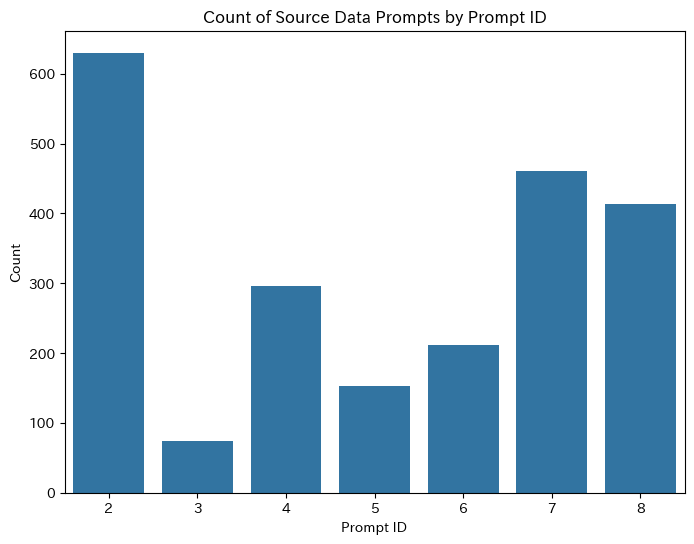

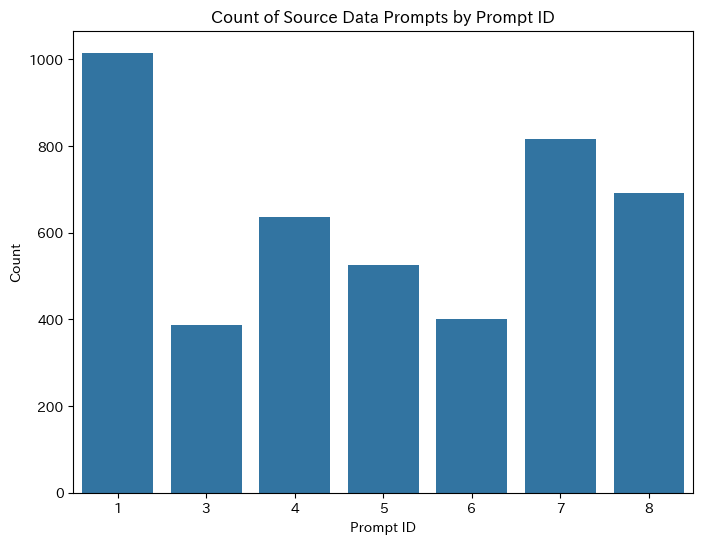

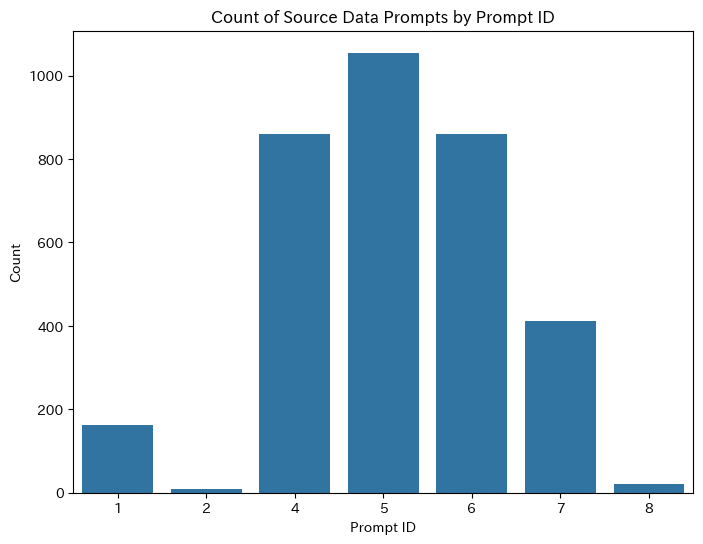

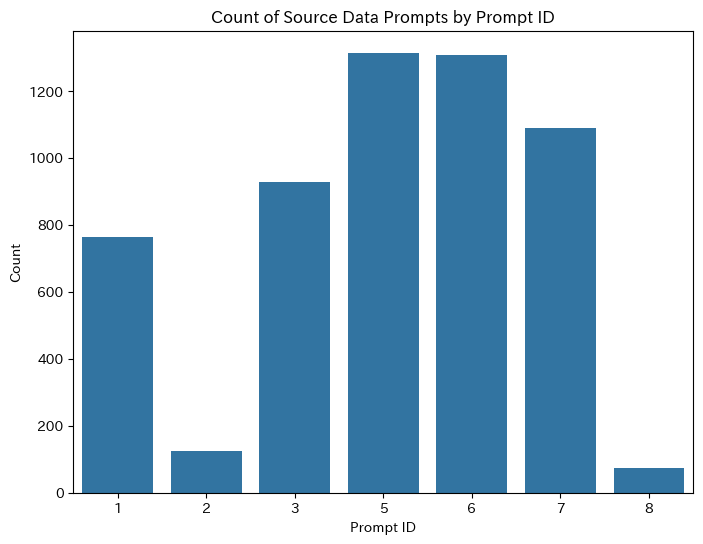

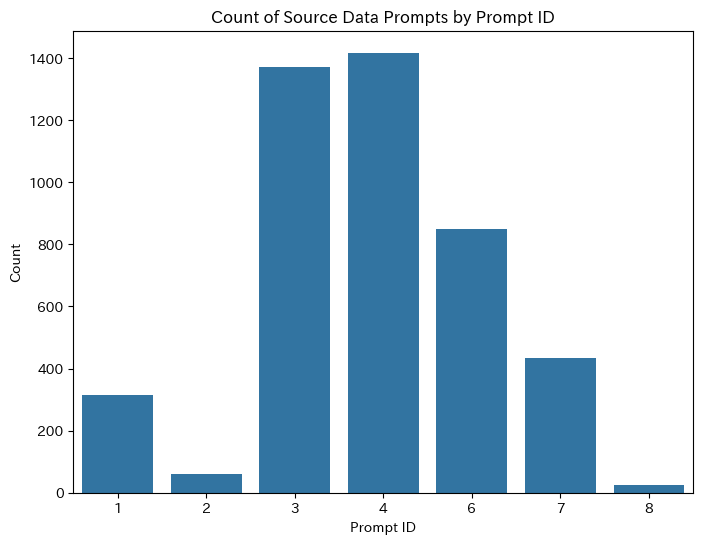

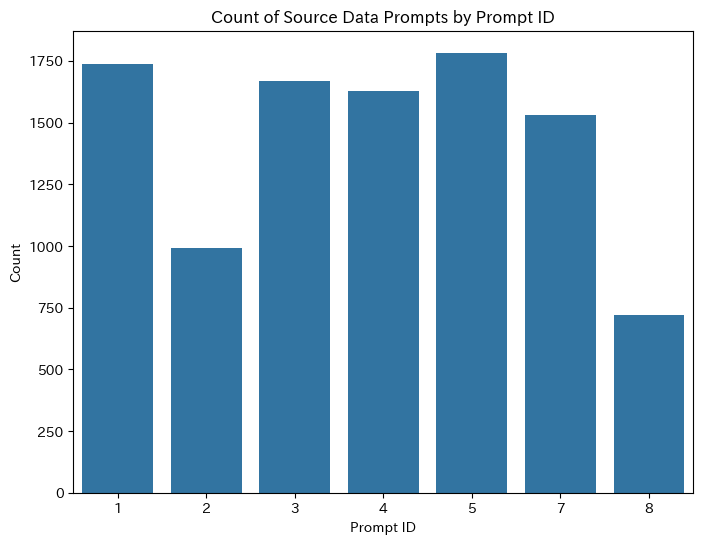

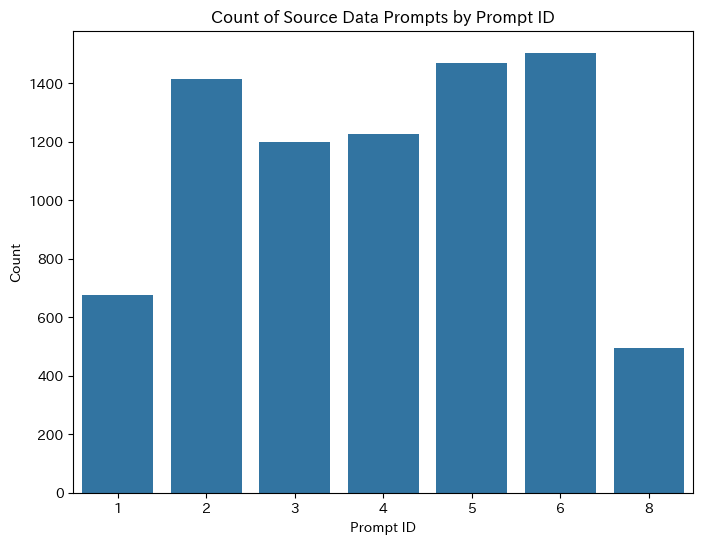

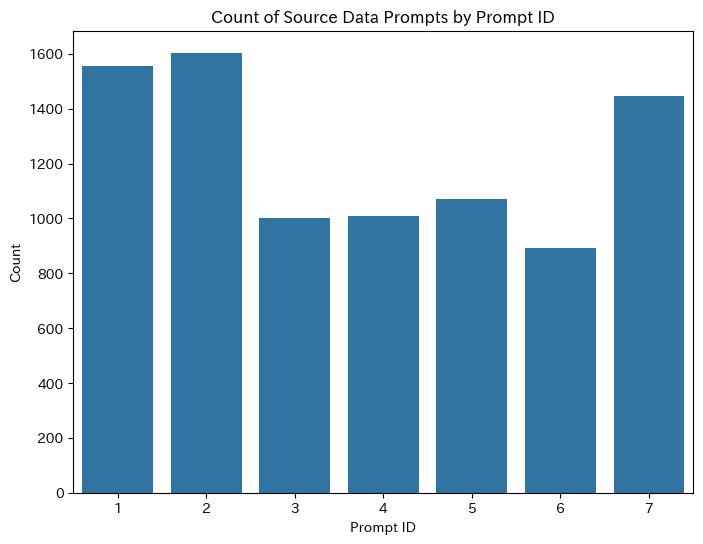

In [26]:
test_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]
top_p_list = [0.8, 0.6, 0.7, 0.5, 0.6, 0.1, 0.3, 0.3]

prompt_arr = []
num_prompts = []
for test_prompt_id, top_p in zip(test_prompt_ids, top_p_list):
    train_data, valid_data, test_data = create_embedding_features(f'data/cross_prompt_attributes/{test_prompt_id}/', 'score', 'microsoft/deberta-v3-large', 'cpu')
    # split test data into dev and test
    x_dev, x_test, y_dev, y_test, dev_idx, test_idx = get_dev_sample(test_data['essay'], test_data['normalized_label'], dev_size=30)

    weights = remove_top_p_sample(np.load('outputs/Estimated_Data_Values/DVRL-word/' + f'estimated_data_value{test_prompt_id}.npy'), top_p=top_p, ascending=False)

    source_data_prompts = np.concatenate([train_data['essay_set'], valid_data['essay_set']], axis=0)
    target_data_prompts = np.array(test_data['essay_set'])[test_idx]

    print('source_data_prompts len:', len(source_data_prompts))
    print('target_data_prompts len:', len(target_data_prompts))
    num_prompts.append(len(np.array(test_data['essay_set'])))

    source_data_prompts = source_data_prompts[weights == 1]

    # Count the occurrences of each unique value in source_data_prompts
    unique, counts = np.unique(source_data_prompts, return_counts=True)
    # Plot the counts
    plt.figure(figsize=(8, 6))
    sns.barplot(x=unique, y=counts)
    plt.xlabel('Prompt ID')
    plt.ylabel('Count')
    plt.title('Count of Source Data Prompts by Prompt ID')
    # plt.savefig('outputs/figures/' + f'count_of_source_data_prompts_by_prompt_id{test_prompt_id}.png')

    count_list = counts.tolist()
    count_list.insert(test_prompt_id-1, 0)
    prompt_arr.append(count_list)


In [27]:
num_prompts = np.array(num_prompts).reshape(1, -1)
num_prompts

array([[1783, 1798, 1726, 1772, 1805, 1800, 1569,  723]])

In [28]:
prompt_arr = np.array(prompt_arr, dtype=float)
prompt_arr

array([[   0.,  630.,   74.,  296.,  153.,  212.,  461.,  413.],
       [1015.,    0.,  388.,  635.,  525.,  401.,  817.,  691.],
       [ 162.,    8.,    0.,  860., 1055.,  859.,  412.,   20.],
       [ 765.,  124.,  927.,    0., 1314., 1308., 1090.,   74.],
       [ 315.,   59., 1371., 1417.,    0.,  848.,  435.,   24.],
       [1738.,  993., 1668., 1629., 1783.,    0., 1529.,  719.],
       [ 677., 1415., 1200., 1227., 1469., 1504.,    0.,  493.],
       [1557., 1604., 1001., 1008., 1071.,  892., 1445.,    0.]])

In [47]:
# 各問題の採択数を正規化
normalized_arr = prompt_arr / num_prompts
normalized_arr

array([[0.        , 0.35038932, 0.0428737 , 0.16704289, 0.08476454,
        0.11777778, 0.29381772, 0.57123098],
       [0.56926528, 0.        , 0.22479722, 0.35835214, 0.29085873,
        0.22277778, 0.52071383, 0.95573997],
       [0.0908581 , 0.00444939, 0.        , 0.48532731, 0.58448753,
        0.47722222, 0.26258764, 0.02766252],
       [0.42905216, 0.06896552, 0.53707995, 0.        , 0.72797784,
        0.72666667, 0.69471001, 0.10235131],
       [0.17666854, 0.03281424, 0.79432213, 0.7996614 , 0.        ,
        0.47111111, 0.27724665, 0.03319502],
       [0.97476164, 0.55228031, 0.96639629, 0.91930023, 0.98781163,
        0.        , 0.97450605, 0.9944675 ],
       [0.37969714, 0.78698554, 0.69524913, 0.69243792, 0.81385042,
        0.83555556, 0.        , 0.68188105],
       [0.87324734, 0.89210234, 0.57995365, 0.56884876, 0.5933518 ,
        0.49555556, 0.92096877, 0.        ]])

In [48]:
import pandas as pd
import numpy as np

conmat = normalized_arr
df_conf_matrix = pd.DataFrame(conmat)

# アノテーション用に対角成分をハイフンに置き換え、それ以外を小数点以下2桁にフォーマット
annot_matrix = df_conf_matrix.copy().values.astype(object)  # Convert to object dtype to allow mixed types
for i in range(len(df_conf_matrix)):
    annot_matrix[i, i] = '-'  # 対角成分をハイフンに
    for j in range(len(df_conf_matrix)):
        if i != j:
            annot_matrix[i, j] = f'{df_conf_matrix.iloc[i, j]:.2f}'  # 小数点以下2桁にフォーマット

In [49]:
annot_matrix

array([['-', '0.35', '0.04', '0.17', '0.08', '0.12', '0.29', '0.57'],
       ['0.57', '-', '0.22', '0.36', '0.29', '0.22', '0.52', '0.96'],
       ['0.09', '0.00', '-', '0.49', '0.58', '0.48', '0.26', '0.03'],
       ['0.43', '0.07', '0.54', '-', '0.73', '0.73', '0.69', '0.10'],
       ['0.18', '0.03', '0.79', '0.80', '-', '0.47', '0.28', '0.03'],
       ['0.97', '0.55', '0.97', '0.92', '0.99', '-', '0.97', '0.99'],
       ['0.38', '0.79', '0.70', '0.69', '0.81', '0.84', '-', '0.68'],
       ['0.87', '0.89', '0.58', '0.57', '0.59', '0.50', '0.92', '-']],
      dtype=object)

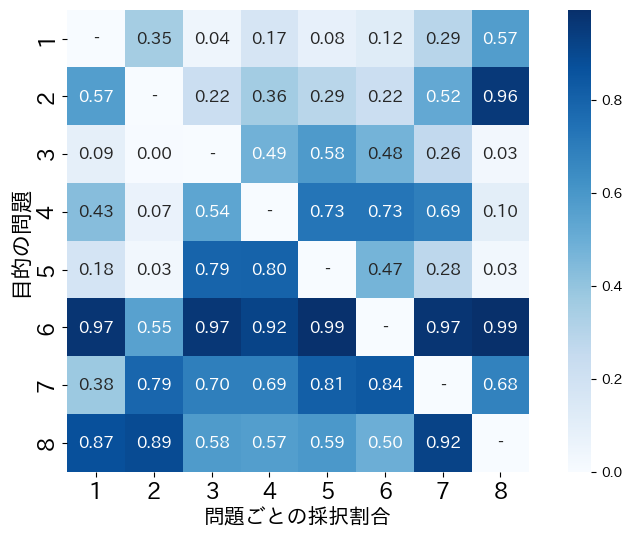

In [51]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    normalized_arr,
    # conmat,
    annot=annot_matrix,
    fmt='',
    cmap='Blues',
    cbar=True,
    square=True,
    xticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    yticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    annot_kws={'size': 12}
)
plt.xlabel('問題ごとの採択割合', fontsize=15)
plt.ylabel('目的の問題', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('outputs/figures/' + f'prompt_usage_rate_v2.png')

## （実験２）回答文の特徴分布の差を問題ごとに計算する

In [8]:
import numpy as np

def gaussian_kernel(x1, x2, sigma=1.0):
    """
    Compute the Gaussian kernel between two vectors.
    
    Args:
        x1: First vector.
        x2: Second vector.
        sigma: Bandwidth of the Gaussian kernel.
        
    Returns:
        The Gaussian kernel between x1 and x2.
    """
    diff = np.linalg.norm(x1 - x2)
    return np.exp(-diff ** 2 / (2 * sigma ** 2))

def squared_MMD(
    source: np.ndarray,
    target: np.ndarray,
    kernel: callable = gaussian_kernel
) -> float:
    """
    Compute the squared maximum mean discrepancy (MMD) between source and target.
    
    Args:
        source: Source data.
        target: Target data.
        kernel: Kernel function.
        
    Returns:
        The squared MMD between source and target.
    """
    m = len(source)
    n = len(target)
    
    mmd_ss = 0.0
    mmd_tt = 0.0
    mmd_st = 0.0

    for i in range(m):
        for j in range(m):
            mmd_ss += kernel(source[i], source[j])
    mmd_ss *= 1.0 / m ** 2
    
    for i in range(n):
        for j in range(n):
            mmd_tt += kernel(target[i], target[j])
    mmd_tt *= 1.0 / n ** 2
    
    for i in range(m):
        for j in range(n):
            mmd_st -= kernel(source[i], target[j])
    mmd_st *= 2.0 / (m * n)
    
    return mmd_ss + mmd_tt + mmd_st

In [19]:
test_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]
source_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]

mmd_matrix = np.zeros((8, 8))
for source_prompt_id in source_prompt_ids:
    for test_prompt_id in test_prompt_ids:
        if test_prompt_id == source_prompt_id:
            continue
        train_data, valid_data, test_data = create_embedding_features(f'data/cross_prompt_attributes/{test_prompt_id}/', 'score', 'microsoft/deberta-v3-large', 'cpu')
        # split test data into dev and test
        x_dev, x_test, y_dev, y_test, dev_idx, test_idx = get_dev_sample(test_data['essay'], test_data['normalized_label'], dev_size=30)

        source_data_prompts = np.concatenate([train_data['essay_set'], valid_data['essay_set']], axis=0)

        source_data_rep = np.concatenate([train_data['essay'], valid_data['essay']], axis=0)[source_data_prompts == source_prompt_id]
        target_data_rep = np.array(test_data['essay'])

        mmd = squared_MMD(source_data_rep, target_data_rep)
        mmd_matrix[test_prompt_id-1, source_prompt_id-1] = mmd
        print(f'MMD between prompt {source_prompt_id} and prompt {test_prompt_id}: {mmd}')

load data from data/cross_prompt_attributes/2/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [341, 1298, 765, 955, 244, 995, 900, 1215, 1398, 573, 988, 182, 1140, 1195, 310, 519, 1710, 1515, 1622, 1632, 725, 1055, 1629, 1000, 1006, 1276, 1198, 502, 366, 1333]
MMD between prompt 1 and prompt 2: 0.023901703138679675
load data from data/cross_prompt_attributes/3/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1425, 785, 1005, 396, 28, 960, 1434, 1302, 941, 1387, 1327, 914, 1620, 1576, 485, 1673, 1422, 1529, 1035, 1573, 1278, 942, 101, 530, 592, 173, 1227, 1571, 1316, 409]
MMD between prompt 1 and prompt 3: 0.586691539971
load data from data/cross_prompt_attributes/4/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [807, 129, 409, 1412, 646, 926, 40, 454, 897, 1707, 334, 285, 191, 705, 760, 49, 900, 1432, 1240, 1393, 1063, 452, 918, 1415, 908, 997, 1145, 236, 1305, 1380]
MMD between promp

In [20]:
mmd_matrix

array([[0.        , 0.0239017 , 0.58669154, 0.59994466, 0.5162282 ,
        0.47878866, 0.31690769, 0.20299087],
       [0.0239017 , 0.        , 0.56406132, 0.57760293, 0.49461276,
        0.4536904 , 0.31431072, 0.15131053],
       [0.58669154, 0.56406132, 0.        , 0.01357968, 0.01726762,
        0.08975505, 0.09627567, 0.81768557],
       [0.59994466, 0.57760292, 0.01357968, 0.        , 0.04903616,
        0.14217847, 0.13766069, 0.81755518],
       [0.51622819, 0.49461275, 0.01726762, 0.04903615, 0.        ,
        0.04235486, 0.05012056, 0.77072052],
       [0.47878866, 0.45369039, 0.08975505, 0.14217847, 0.04235487,
        0.        , 0.06521653, 0.75436992],
       [0.31690769, 0.31431072, 0.09627567, 0.13766069, 0.05012056,
        0.06521653, 0.        , 0.60719368],
       [0.20299087, 0.15131053, 0.81768558, 0.81755518, 0.77072053,
        0.75436993, 0.60719368, 0.        ]])

In [21]:
np.save('outputs/figures/mmd_matrix.npy', mmd_matrix)

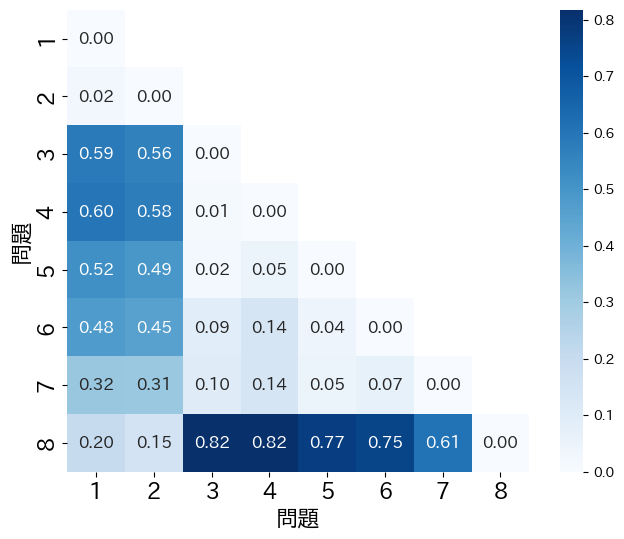

In [22]:
plt.figure(figsize=(8, 6))
mask = np.tril(np.ones((8, 8), dtype=bool), 0)
sns.heatmap(
    mmd_matrix,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar=True,
    square=True,
    xticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    yticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    mask=~mask,
    annot_kws={'fontsize': 12}
)
plt.xlabel('問題', fontsize=16)
plt.ylabel('問題', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('MMD between Source and Target Prompts')
plt.savefig('outputs/figures/mmd_matrix.png')

In [29]:
mmd_vec = mmd_matrix.flatten()

In [30]:
usage_vec = normalized_arr.flatten()

In [34]:
np.corrcoef(mmd_vec, usage_vec)

array([[ 1.        , -0.15346218],
       [-0.15346218,  1.        ]])

In [33]:
np.corrcoef(mmd_vec, conmat.flatten())

array([[ 1.        , -0.30048094],
       [-0.30048094,  1.        ]])

# （実験３）曲線下面積を分析する

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SETTING = 'dvrl'
MODEL = 'paes'

In [3]:
df_high = pl.read_csv(f'outputs/qwk/{SETTING}_{MODEL}_high.csv')
df_high = df_high.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_high = df_high.select(sorted(df_high.columns))

df_low = pl.read_csv(f'outputs/qwk/{SETTING}_{MODEL}_low.csv')
df_low = df_low.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_low = df_low.select(sorted(df_low.columns))

In [18]:
df_high[['Step', 'PAES-DVRL(Predictor feature)-nodev3 - best_test_qwk_high']].write_csv('high3.csv')
df_low[['Step', 'PAES-DVRL(Predictor feature)-nodev3 - best_test_qwk_low']].write_csv('low3.csv')

In [4]:
df_high

PAES-DVRL(Predictor feature)-nodev1 - best_test_qwk_high,PAES-DVRL(Predictor feature)-nodev2 - best_test_qwk_high,PAES-DVRL(Predictor feature)-nodev3 - best_test_qwk_high,PAES-DVRL(Predictor feature)-nodev4 - best_test_qwk_high,PAES-DVRL(Predictor feature)-nodev5 - best_test_qwk_high,PAES-DVRL(Predictor feature)-nodev6 - best_test_qwk_high,PAES-DVRL(Predictor feature)-nodev7 - best_test_qwk_high,PAES-DVRL(Predictor feature)-nodev8 - best_test_qwk_high,Step
f64,f64,f64,f64,f64,f64,f64,f64,i64
0.756302,0.595861,0.609873,0.595341,0.687834,0.565637,0.706717,0.538131,0
0.739699,0.613851,0.587712,0.600453,0.726351,0.612406,0.73737,0.51009,1
0.802234,0.597689,0.619583,0.607216,0.722335,0.629824,0.735349,0.478589,2
0.792094,0.59956,0.63275,0.607372,0.748557,0.63303,0.716705,0.46865,3
0.793816,0.575491,0.584815,0.653086,0.746805,0.602817,0.564858,0.269574,4
0.793806,0.448048,0.661974,0.6235,0.702792,0.573135,0.709624,0.307514,5
0.786732,0.497809,0.667394,0.695669,0.714885,0.641211,0.643367,0.271037,6
0.764168,0.407977,0.654548,0.681136,0.69242,0.607764,0.665175,0.192502,7
0.663284,0.440719,0.605543,0.704915,0.693381,0.603624,0.442911,0.14646,8


In [5]:
df_low

PAES-DVRL(Predictor feature)-nodev1 - best_test_qwk_low,PAES-DVRL(Predictor feature)-nodev2 - best_test_qwk_low,PAES-DVRL(Predictor feature)-nodev3 - best_test_qwk_low,PAES-DVRL(Predictor feature)-nodev4 - best_test_qwk_low,PAES-DVRL(Predictor feature)-nodev5 - best_test_qwk_low,PAES-DVRL(Predictor feature)-nodev6 - best_test_qwk_low,PAES-DVRL(Predictor feature)-nodev7 - best_test_qwk_low,PAES-DVRL(Predictor feature)-nodev8 - best_test_qwk_low,Step
f64,f64,f64,f64,f64,f64,f64,f64,i64
0.756302,0.595861,0.609873,0.595341,0.687834,0.565637,0.706717,0.538131,0
0.622976,0.592899,0.605754,0.532239,0.625441,0.493313,0.713449,0.53159,1
0.607215,0.597774,0.515369,0.565535,0.612672,0.523129,0.720007,0.587286,2
0.613758,0.540145,0.259278,0.564544,0.621288,0.43079,0.727002,0.564613,3
0.54883,0.526014,0.233507,0.506661,0.603275,0.380783,0.686791,0.5544,4
0.439658,0.558394,0.201215,0.540085,0.625133,0.462492,0.662402,0.459037,5
0.444956,0.545146,0.183666,0.551022,0.581399,0.407027,0.66158,0.553862,6
0.375235,0.527498,0.050995,0.375495,0.417046,0.316259,0.579748,0.559914,7
0.287035,0.4515,0.029424,0.500227,0.458614,0.165561,0.592905,0.544892,8


In [6]:
areas = []
for col in sorted(df_low.columns[1:]):
    area = np.trapz(df_low[col], dx=1)
    areas.append(f'{area:.2f}')

mean_area = np.mean([float(area) for area in areas])
print(' & '.join(areas) + f' & {mean_area:.2f}')

4.78 & 2.39 & 4.49 & 5.13 & 3.52 & 5.98 & 4.90 & 40.50 & 8.96


In [7]:
areas = []
for col in sorted(df_high.columns[1:]):
    area = np.trapz(df_high[col], dx=1)
    areas.append(f'{area:.2f}')

mean_area = np.mean([float(area) for area in areas])
print(' & '.join(areas) + f' & {mean_area:.2f}')

4.53 & 5.59 & 5.77 & 6.37 & 5.45 & 5.59 & 2.95 & 40.50 & 9.59


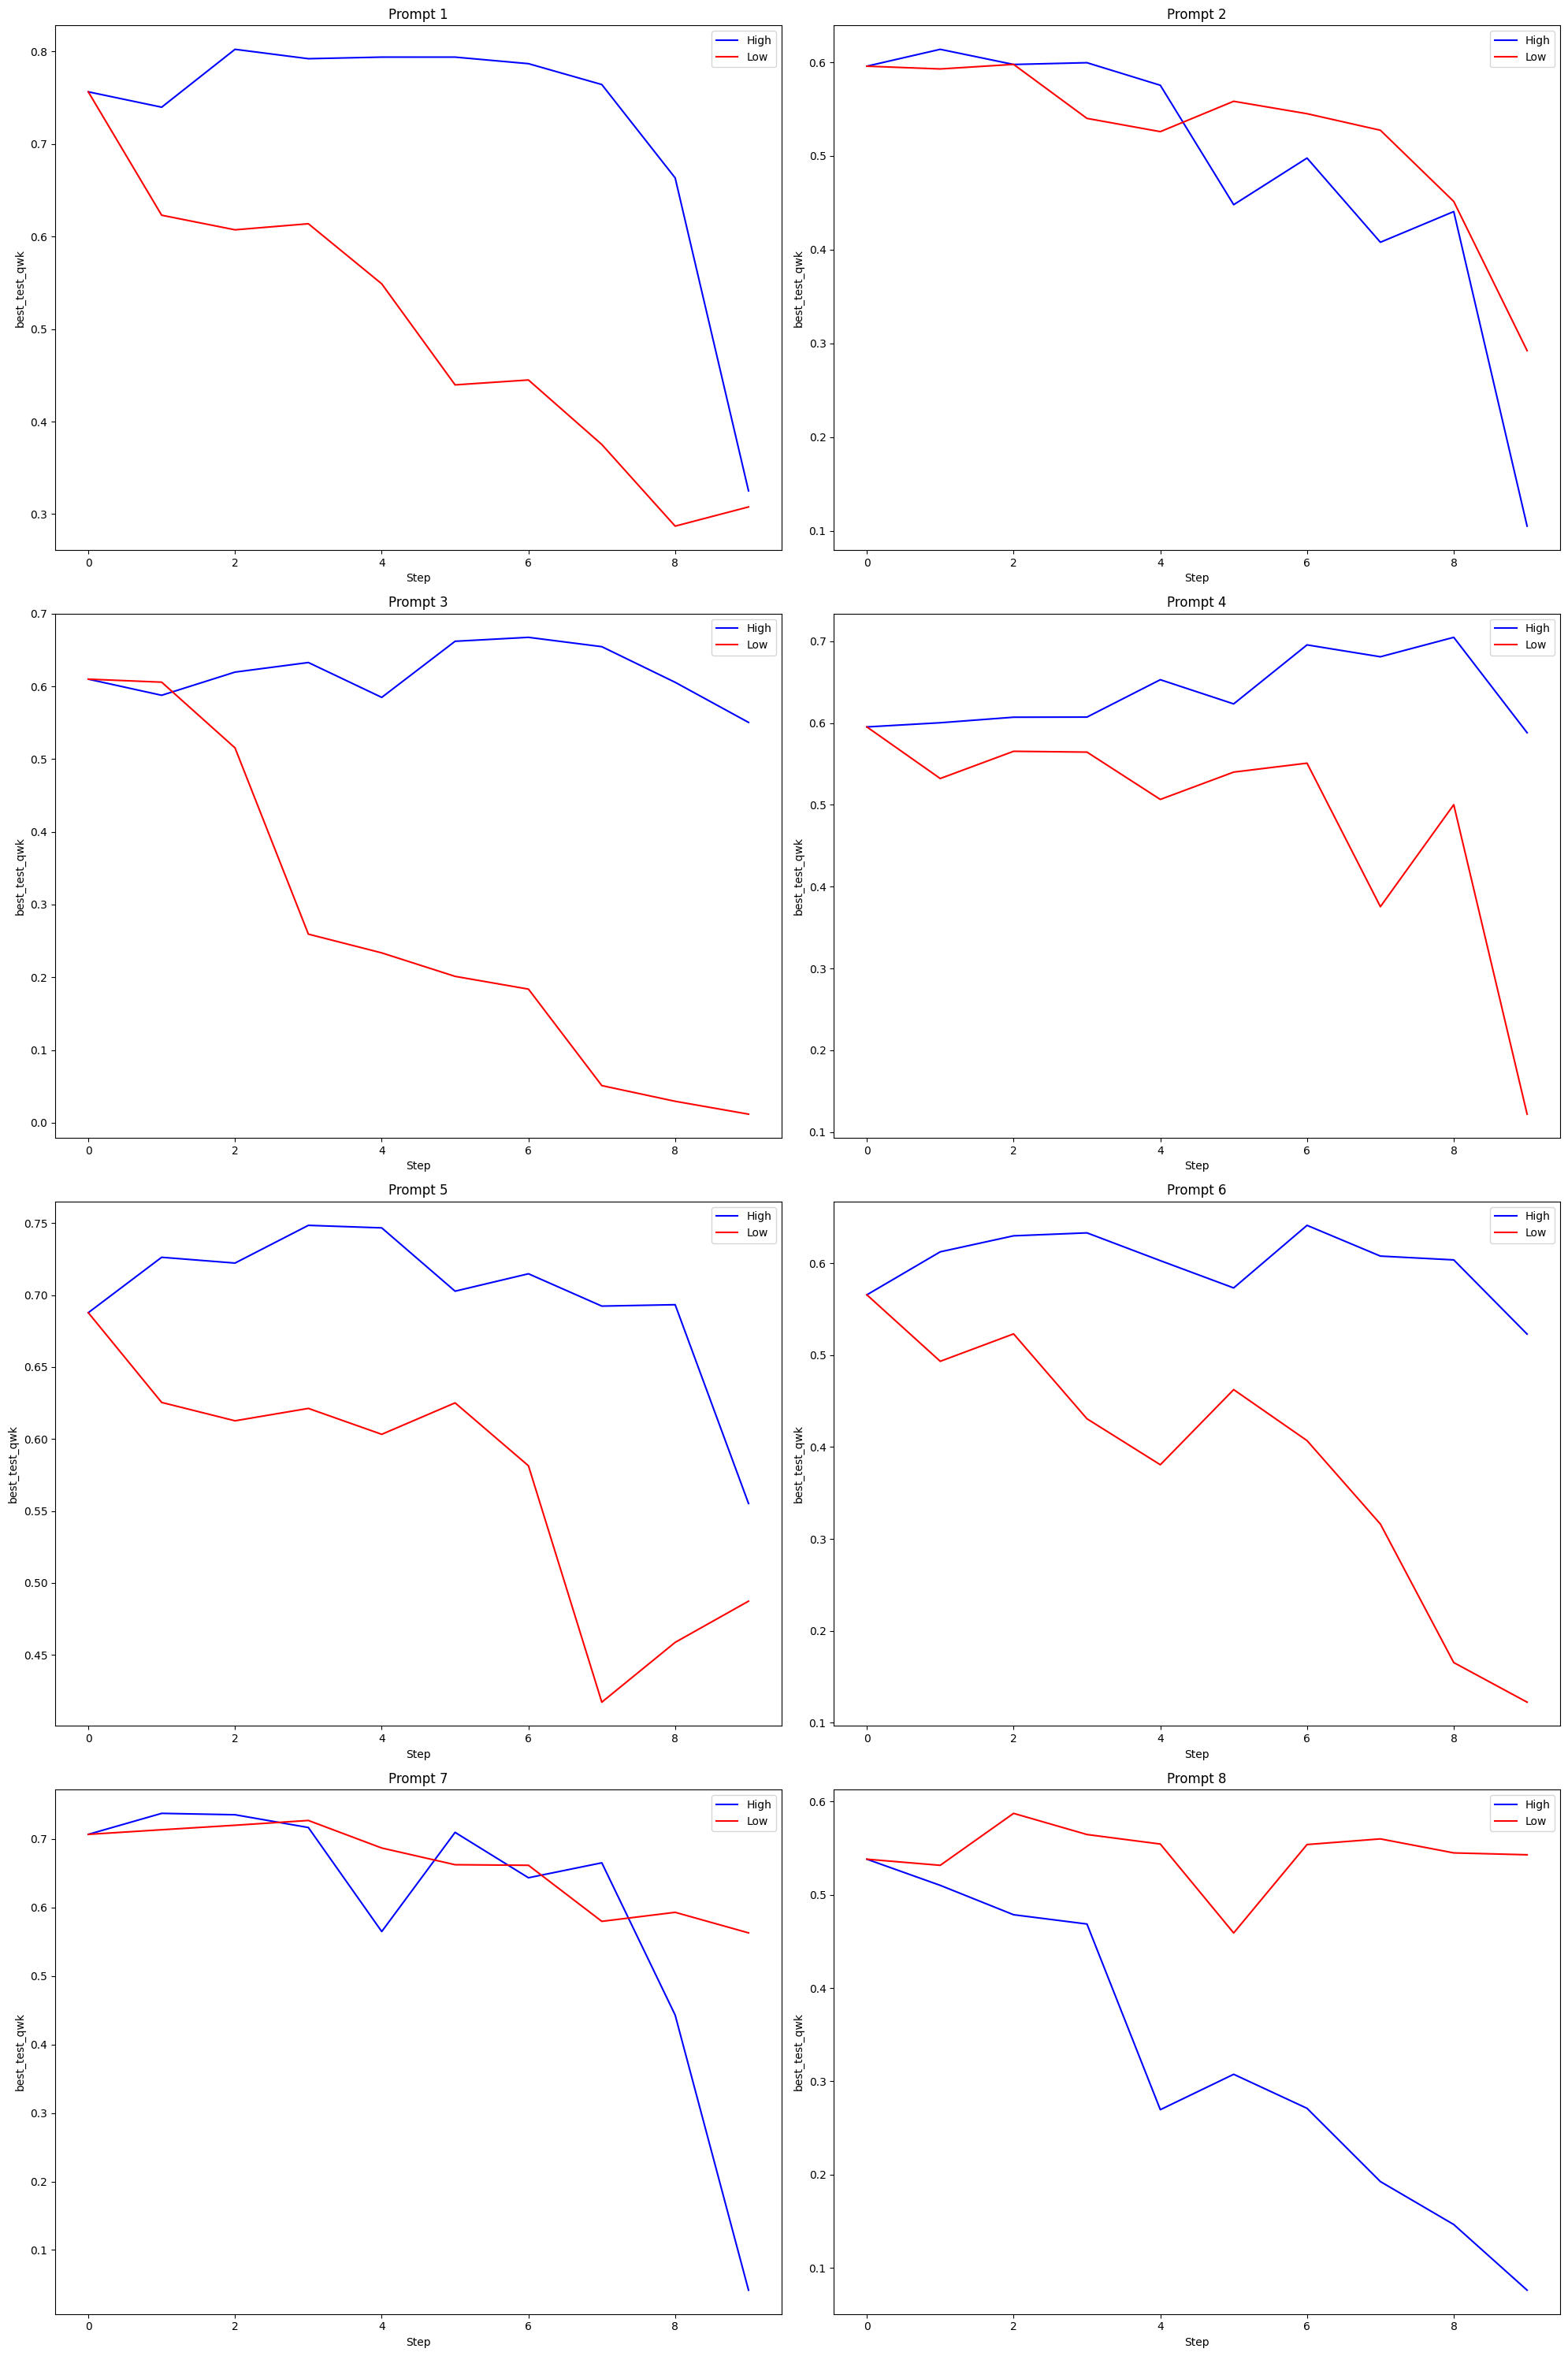

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(20, 30))

for target_prompt in range(1, 9):
    row = (target_prompt - 1) // 2
    col = (target_prompt - 1) % 2
    
    # Plot for high
    axs[row, col].plot(df_high['Step'], df_high[df_high.columns[target_prompt-1]], label='High', color='blue')
    
    # Plot for low
    axs[row, col].plot(df_low['Step'], df_low[df_low.columns[target_prompt-1]], label='Low', color='red')
    
    axs[row, col].set_title(f'Prompt {target_prompt}')
    axs[row, col].set_xlabel('Step')
    axs[row, col].set_ylabel('best_test_qwk')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

In [25]:
PROMPT = 3

In [26]:
df_high_loo = pl.read_csv(f'outputs/qwk/loo_bert_high.csv')
df_high_loo = df_high_loo.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_high_loo = df_high_loo.select(sorted(df_high_loo.columns))[f'train-BERT{PROMPT} - best_test_qwk_high']

In [27]:
df_high_ds = pl.read_csv(f'outputs/qwk/ds_bert_high.csv')
df_high_ds = df_high_ds.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_high_ds = df_high_ds.select(sorted(df_high_ds.columns))[f'train-BERT{PROMPT} - best_test_qwk_high']

In [28]:
df_high_dvrl = pl.read_csv(f'outputs/qwk/dvrl_bert_high.csv')
df_high_dvrl = df_high_dvrl.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_high_dvrl = df_high_dvrl.select(sorted(df_high_dvrl.columns))[f'train-BERT{PROMPT} - best_test_qwk_high']

In [31]:
df_high = pl.DataFrame({
    'step': np.arange(0, 10),
    'loo': df_high_loo,
    'ds': df_high_ds,
    'dvrl': df_high_dvrl
})
df_high = df_high.with_columns(pl.when(pl.col('step') == 0).then(pl.lit(0.578)).otherwise(pl.col('loo')).alias('loo'))
df_high = df_high.with_columns(pl.when(pl.col('step') == 0).then(pl.lit(0.578)).otherwise(pl.col('ds')).alias('ds'))
df_high = df_high.with_columns(pl.when(pl.col('step') == 0).then(pl.lit(0.578)).otherwise(pl.col('dvrl')).alias('dvrl'))
df_high

step,loo,ds,dvrl
i64,f64,f64,f64
0,0.578,0.578,0.578
1,0.553669,0.62371,0.611681
2,0.585846,0.602482,0.624731
3,0.596594,0.627412,0.586368
4,0.602113,0.540559,0.633559
5,0.595554,0.588443,0.667133
6,0.557983,0.547413,0.666864
7,0.64088,0.591261,0.637693
8,0.631123,0.451608,0.667158


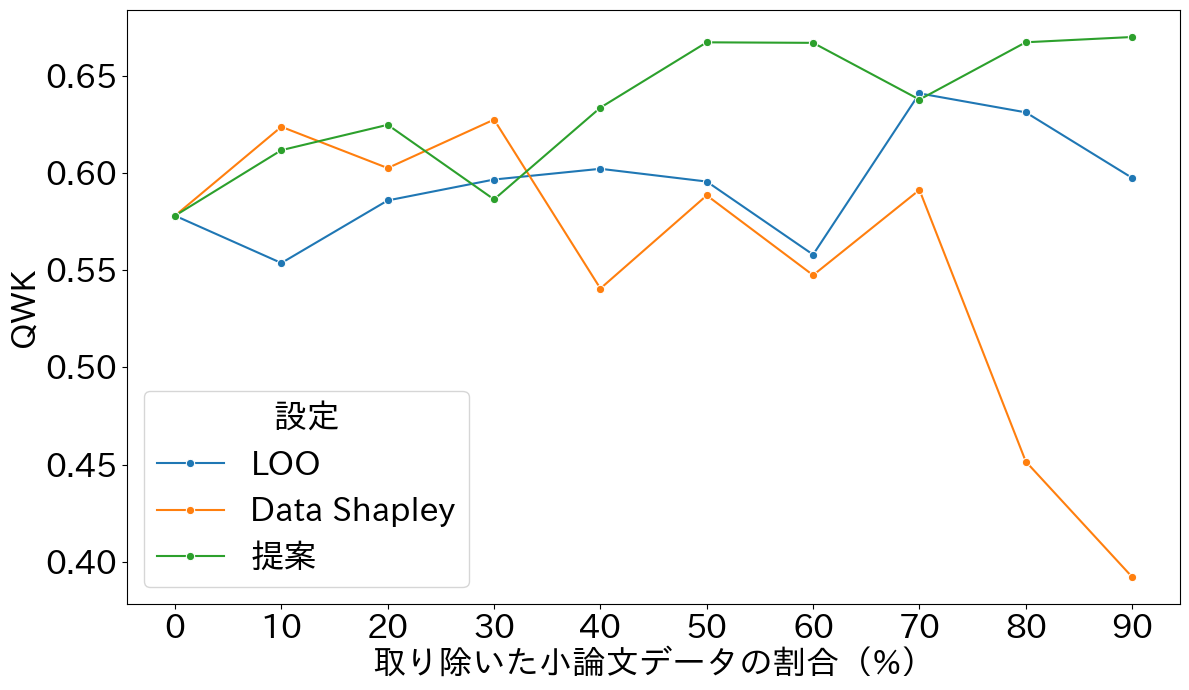

In [35]:
import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt

# Create a figure with a specific size
plt.figure(figsize=(12, 7))

# Create the line plot
sns.lineplot(data=df_high, x='step', y='loo', label='LOO', marker='o')
sns.lineplot(data=df_high, x='step', y='ds', label='Data Shapley', marker='o')
sns.lineplot(data=df_high, x='step', y='dvrl', label='提案', marker='o')

# Customize the plot
plt.xlabel('取り除いた小論文データの割合（%）', fontsize=24)
plt.ylabel('QWK', fontsize=24)
plt.xticks(fontsize=24, ticks=np.arange(0, 10, 1), labels=[f'{i}' for i in range(0, 100, 10)])
plt.yticks(fontsize=24)
plt.legend(title='設定', title_fontsize=24, fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
df_low_dvrl

Step,debertav3large-DVRL-nodev1 - best_test_qwk_high,debertav3large-DVRL-nodev2 - best_test_qwk_high,debertav3large-DVRL-nodev3 - best_test_qwk_high,debertav3large-DVRL-nodev4 - best_test_qwk_high,debertav3large-DVRL-nodev5 - best_test_qwk_high,debertav3large-DVRL-nodev6 - best_test_qwk_high,debertav3large-DVRL-nodev7 - best_test_qwk_high,debertav3large-DVRL-nodev8 - best_test_qwk_high
i64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.360793,0.473572,0.577468,0.609723,0.72385,0.602817,0.532725,0.365492
1,0.425496,0.445192,0.0,0.593959,0.749703,0.659796,0.502505,0.359604
2,0.417678,0.457059,0.621086,0.600755,0.751066,0.64424,0.470618,0.468536
3,0.467723,0.420954,0.621156,0.623975,0.758636,0.644751,0.48184,0.618625
4,0.477227,0.463365,0.601395,0.606861,0.726526,0.603786,0.498252,0.599066
5,0.460874,0.439613,0.632241,0.635914,0.780214,0.585548,0.492334,0.561243
6,0.411334,0.56383,0.640122,0.623182,0.721571,0.541051,0.565526,0.323668
7,0.331128,0.471864,0.665302,0.660854,0.739903,0.396873,0.384601,0.325626
8,0.458374,0.472061,0.681899,0.631807,0.559916,0.419619,0.410542,0.228341


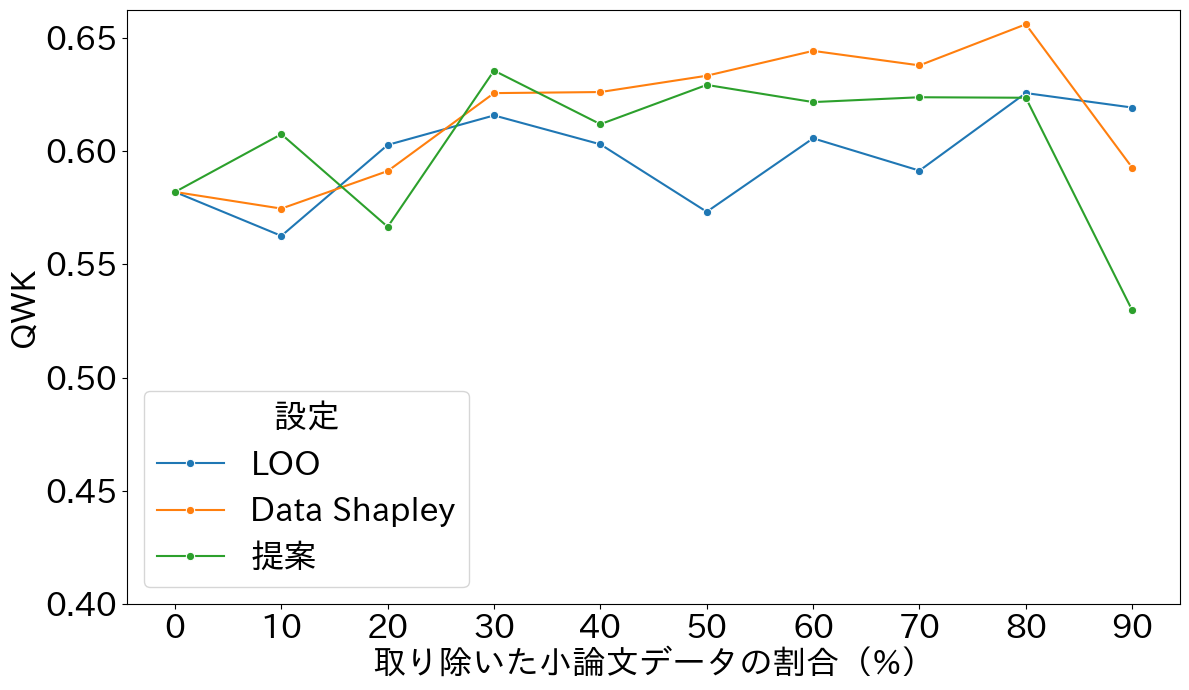

In [37]:
PROMPT = 4
df_low_loo = pl.read_csv(f'outputs/qwk/loo_bert_high.csv')
df_low_loo = df_low_loo.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_low_loo = df_low_loo.select(sorted(df_low_loo.columns))[f'train-BERT{PROMPT} - best_test_qwk_high']

df_low_ds = pl.read_csv(f'outputs/qwk/ds_bert_high.csv')
df_low_ds = df_low_ds.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_low_ds = df_low_ds.select(sorted(df_low_ds.columns))[f'train-BERT{PROMPT} - best_test_qwk_high']

df_low_dvrl = pl.read_csv(f'outputs/qwk/dvrl_bert_high.csv')
df_low_dvrl = df_low_dvrl.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_low_dvrl = df_low_dvrl.select(sorted(df_low_dvrl.columns))[f'train-BERT{PROMPT} - best_test_qwk_high']

df_low = pl.DataFrame({
    'step': np.arange(0, 10),
    'loo': df_low_loo,
    'ds': df_low_ds,
    'dvrl': df_low_dvrl
})
df_low = df_low.with_columns(pl.when(pl.col('step') == 0).then(pl.lit(0.582)).otherwise(pl.col('loo')).alias('loo'))
df_low = df_low.with_columns(pl.when(pl.col('step') == 0).then(pl.lit(0.582)).otherwise(pl.col('ds')).alias('ds'))
df_low = df_low.with_columns(pl.when(pl.col('step') == 0).then(pl.lit(0.582)).otherwise(pl.col('dvrl')).alias('dvrl'))
df_low

import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt

# Create a figure with a specific size
plt.figure(figsize=(12, 7))

# Create the line plot
sns.lineplot(data=df_low, x='step', y='loo', label='LOO', marker='o')
sns.lineplot(data=df_low, x='step', y='ds', label='Data Shapley', marker='o')
sns.lineplot(data=df_low, x='step', y='dvrl', label='提案', marker='o')

# Customize the plot
plt.xlabel('取り除いた小論文データの割合（%）', fontsize=24)
plt.ylabel('QWK', fontsize=24)
plt.xticks(fontsize=24, ticks=np.arange(0, 10, 1), labels=[f'{i}' for i in range(0, 100, 10)])
plt.yticks(fontsize=24, ticks=np.arange(0.4, 0.7, 0.05))
plt.legend(title='設定', title_fontsize=24, fontsize=24, loc='lower left')

# Show the plot
plt.tight_layout()
plt.show()

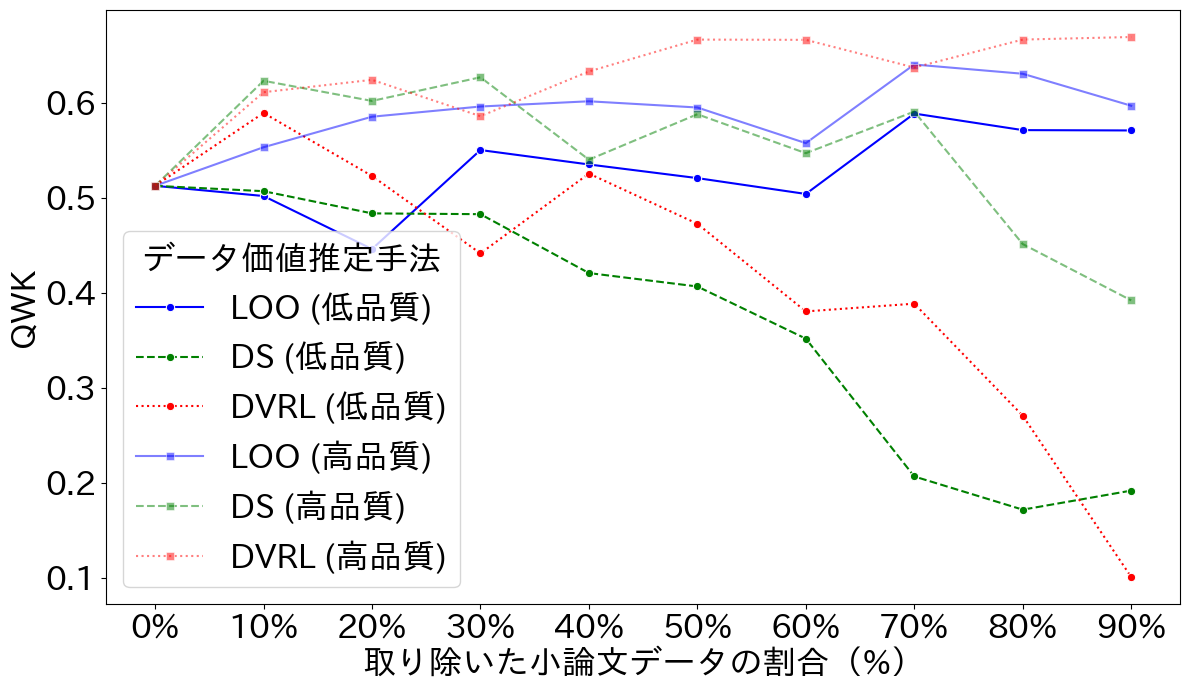

In [335]:
df_low_loo = pl.read_csv(f'outputs/qwk/loo_bert_low.csv')
df_low_loo = df_low_loo.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_low_loo = df_low_loo.select(sorted(df_low_loo.columns))[f'train-BERT{PROMPT} - best_test_qwk_low']

df_low_ds = pl.read_csv(f'outputs/qwk/ds_bert_low.csv')
df_low_ds = df_low_ds.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_low_ds = df_low_ds.select(sorted(df_low_ds.columns))[f'train-BERT{PROMPT} - best_test_qwk_low']

df_low_dvrl = pl.read_csv(f'outputs/qwk/dvrl_bert_low.csv')
df_low_dvrl = df_low_dvrl.select(pl.exclude('^.*__MIN$|^.*__MAX$'))
df_low_dvrl = df_low_dvrl.select(sorted(df_low_dvrl.columns))[f'train-BERT{PROMPT} - best_test_qwk_low']

df_low = pl.DataFrame({
    'step': np.arange(0, 10),
    'loo': df_low_loo,
    'ds': df_low_ds,
    'dvrl': df_low_dvrl
})
df_low = df_low.with_columns(pl.when(pl.col('step') == 0).then(pl.lit(0.513)).otherwise(pl.col('loo')).alias('loo'))
df_low = df_low.with_columns(pl.when(pl.col('step') == 0).then(pl.lit(0.513)).otherwise(pl.col('ds')).alias('ds'))
df_low = df_low.with_columns(pl.when(pl.col('step') == 0).then(pl.lit(0.513)).otherwise(pl.col('dvrl')).alias('dvrl'))
df_low

import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt

# Create a figure with a specific size
plt.figure(figsize=(12, 7))

# Create the line plot
# Define line styles and colors for each method
line_styles = {'loo': '-', 'ds': '--', 'dvrl': ':'}
colors = {'loo': 'blue', 'ds': 'green', 'dvrl': 'red'}

# Plot lines for df_low
for method in ['loo', 'ds', 'dvrl']:
    sns.lineplot(data=df_low, x='step', y=method, 
                 label=f'{method.upper()} (低品質)', 
                 marker='o', linestyle=line_styles[method], 
                 color=colors[method])

# Plot lines for df_high
for method in ['loo', 'ds', 'dvrl']:
    sns.lineplot(data=df_high, x='step', y=method, 
                 label=f'{method.upper()} (高品質)', 
                 marker='s', linestyle=line_styles[method], 
                 color=colors[method], alpha=0.5)

# Customize the legend
plt.legend(title='データ価値推定手法', title_fontsize=20, fontsize=16, 
           loc='lower left', ncol=2)

# Customize the plot
plt.xlabel('取り除いた小論文データの割合（%）', fontsize=24)
plt.ylabel('QWK', fontsize=24)
plt.xticks(fontsize=24, ticks=np.arange(0, 10, 1), labels=[f'{i}%' for i in range(0, 100, 10)])
plt.yticks(fontsize=24)
plt.legend(title='データ価値推定手法', title_fontsize=24, fontsize=24, loc='lower left')

# Show the plot
plt.tight_layout()
plt.show()